In [ ]:
 # Simulador: order-finding para N=15 y a=2

# Simulador: order-finding para N=15 y a=2

Instalación en tu entorno / VAlidacion del entorno over the env  existente.

In [2]:
import importlib

def check_package(pkg_name):
    try:
        importlib.import_module(pkg_name)
        print(f"✓ '{pkg_name}' está instalado.")
        return True
    except ImportError:
        print(f"✗ '{pkg_name}' NO está instalado.")
        return False


# Lista de librerías a validar
paquetes = [
    "requests",
    "qiskit",
    "qiskit_aer",           # nombre correcto para importar
    "qiskit_ibm_runtime",   # nombre correcto para importar
    "matplotlib"
]

# Validación
for pkg in paquetes:
    check_package(pkg)


✓ 'requests' está instalado.
✓ 'qiskit' está instalado.
✓ 'qiskit_aer' está instalado.
✓ 'qiskit_ibm_runtime' está instalado.
✓ 'matplotlib' está instalado.


In [ ]:
# pip install -U qiskit qiskit-aer qiskit-ibm-runtime matplotlib

Celda 1:  Imports + helpers clásicos (gcd, continued fractions)

In [3]:
from math import gcd
from fractions import Fraction

def recover_order_from_measurement(bitstring: str, t: int, a: int, N: int, max_den: int = 256):
    """
    Dado un resultado medido (bitstring) del registro de fase,
    intenta recuperar r usando fracciones continuas, validando con pow(a, r, N)==1.
    """
    y = int(bitstring, 2)
    phase = y / (2**t)
    frac = Fraction(phase).limit_denominator(max_den)

    # candidatos: denominador y algunos múltiplos pequeños
    candidates = [frac.denominator] + [frac.denominator * m for m in range(2, 9)]

    for r in candidates:
        if r > 1 and pow(a, r, N) == 1:
            return r, y, phase, frac

    return None, y, phase, frac


def shor_classical_postprocess(a: int, N: int, r: int):
    """
    Dado a, N y el orden r, intenta devolver los factores no triviales.
    """
    if r is None or r % 2 != 0:
        return None

    x = pow(a, r // 2, N)
    if x == N - 1:   # x ≡ -1 (mod N)
        return None

    p = gcd(x - 1, N)
    q = gcd(x + 1, N)

    if 1 < p < N and 1 < q < N:
        return (p, q)
    return None


🧠 Resumen corto

gcd(a, b) → Máximo común divisor

mod → Resto de una división

x ≡ y (mod N) → x y y dejan el mismo resto al dividir por N

|y⟩ → |a·y mod N⟩ → Multiplicación modular (clave en Shor)

Celda 2 — Parámetros del demo (N=15) + elegir a
Para 
𝑁 = 15 N=15 típicamente elegimos  𝑎 ∈ {2,4,7,8,11,13,14}
a∈{2,4,7,8,11,13,14} coprimo con 15.
Usaremos a = 2 (muy común en el demo).

In [4]:
N = 15
a = 2

print("gcd(a, N) =", gcd(a, N))
# Si esto diera ≠1, ya tienes un factor “gratis”. Para a=2, debe dar 1.


gcd(a, N) = 1


Celda 3 — Construir el unitario U(a): multiplicación modular como permutación

Para 
𝑁
=
15
N=15, necesitamos 
𝑛
=
4
n=4 qubits para el registro work (porque 
2
4
=
16
2
4
=16).

Esta celda crea el unitario:

𝑈
𝑎
:
∣
𝑦
⟩
↦
∣
𝑎
⋅
𝑦
 
m
o
d
 
15
⟩
U
a
	​

:∣y⟩↦∣a⋅ymod15⟩

(En este caso, como 

𝑁
=
15
N=15 y 
2
4
=
16
2
4
=16, todos los estados 0..14 se mapean dentro de 0..14; y el estado 15 lo dejamos fijo.)

In [5]:
import numpy as np
from qiskit.circuit.library import UnitaryGate

def make_U_mul_mod_N(a: int, N: int, n: int) -> UnitaryGate:
    dim = 2**n
    U = np.zeros((dim, dim), dtype=complex)

    for y in range(dim):
        if y < N:
            y2 = (a * y) % N
        else:
            y2 = y
        U[y2, y] = 1.0

    return UnitaryGate(U, label=f"U_mul_{a}_mod_{N}")


n = 4
U = make_U_mul_mod_N(a, N, n)
print("Unitary dimension:", 2**n, "x", 2**n)


Unitary dimension: 16 x 16


Celda 4 — Construir QPE (order finding) con iQFT

Hacemos Quantum Phase Estimation con:

t qubits en el registro de fase (ej. 8)

n=4 qubits en work

inicializamos work en 
∣
1
⟩
∣1⟩

Luego aplicamos controlados 
𝑈
2
𝑗
U
2
j
 y una iQFT (QFT inversa) para leer la fase.
(QFT y Aer son parte del stack estándar)

C:\Users\caraq\AppData\Local\Temp\ipykernel_14300\1718124993.py:24: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse=True, do_swaps=True).to_gate(label="iQFT"), q_phase)


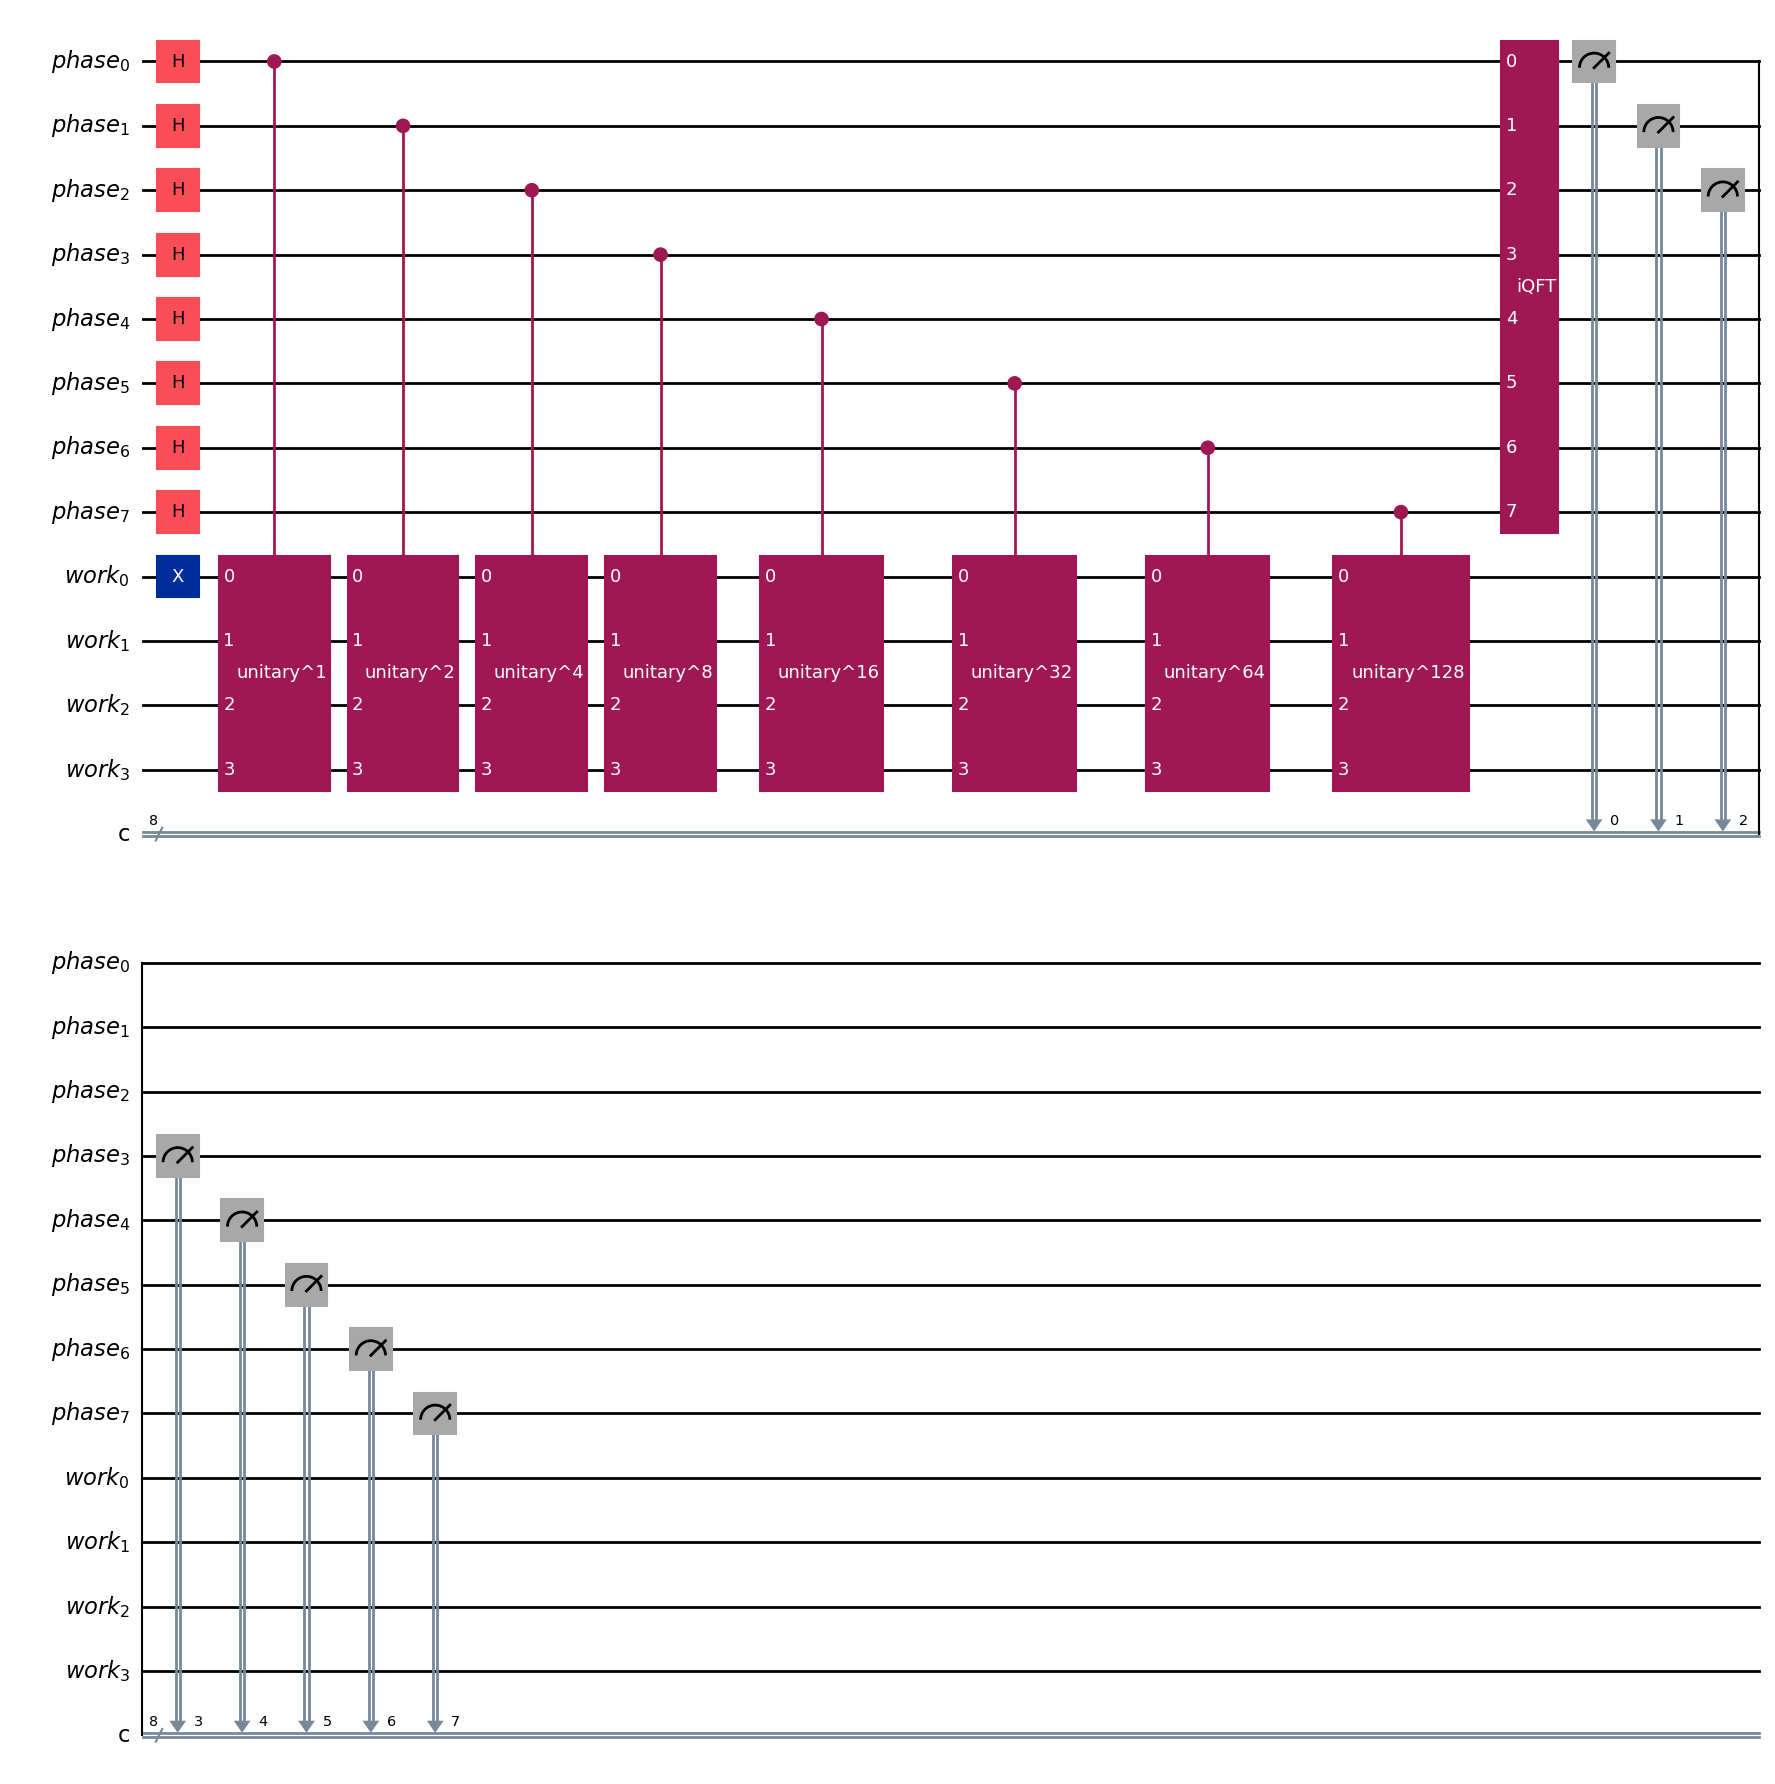

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

def build_qpe_order_finding(a: int, N: int, t: int, n: int) -> QuantumCircuit:
    q_phase = QuantumRegister(t, "phase")
    q_work = QuantumRegister(n, "work")
    c_phase = ClassicalRegister(t, "c")
    qc = QuantumCircuit(q_phase, q_work, c_phase)

    # superposición en fase
    qc.h(q_phase)

    # work = |1>
    qc.x(q_work[0])

    U = make_U_mul_mod_N(a, N, n)

    # controlled-U^(2^j)
    for j in range(t):
        U_pow = U.power(2**j).control(1)
        qc.append(U_pow, [q_phase[j]] + list(q_work))

    # iQFT
    qc.append(QFT(t, inverse=True, do_swaps=True).to_gate(label="iQFT"), q_phase)

    # medir fase
    qc.measure(q_phase, c_phase)
    return qc


t = 8
qc = build_qpe_order_finding(a, N, t, n)
qc.draw("mpl")


Celda 5 — Ejecutar en simulador (AerSimulator) y ver histograma

AerSimulator es el simulador de alto rendimiento de Qiskit

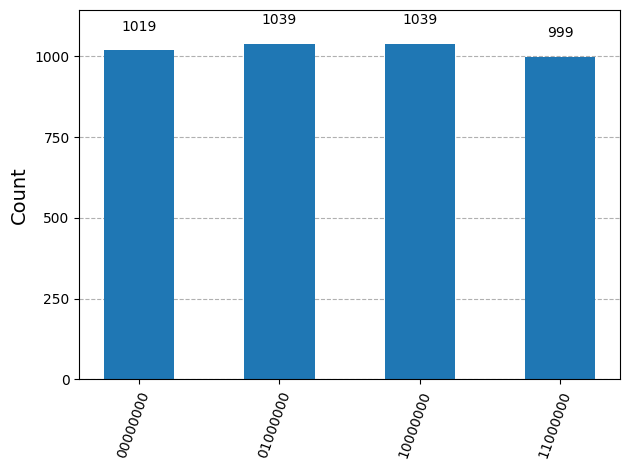

In [7]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

shots = 4096
backend = AerSimulator()

tqc = transpile(qc, backend, optimization_level=1)
result = backend.run(tqc, shots=shots).result()
counts = result.get_counts()

plot_histogram(counts)


Celda 6 — Recuperar el orden r desde los resultados medidos

Aquí tomamos los bitstrings más probables y tratamos de recuperar r con fracciones continuas.

Para 
𝑁
=
15
,
𝑎
=
2
N=15,a=2, el orden real suele ser r = 4 porque:

2
4
=
16
≡
1
(
m
o
d
15
)
2
4
=16≡1(mod15)

In [8]:
# ordenar mediciones por frecuencia
top = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)

found = None
for bitstring, c in top[:20]:
    r, y, phase, frac = recover_order_from_measurement(bitstring, t, a, N)
    if r is not None:
        found = (bitstring, c, r, y, phase, frac)
        break

print("Top 10 outcomes:")
for s, c in top[:10]:
    print(s, c)

print("\nRecovered:")
print(found)


Top 10 outcomes:
01000000 1039
10000000 1039
00000000 1019
11000000 999

Recovered:
('01000000', 1039, 4, 64, 0.25, Fraction(1, 4))


Celda 7 — Factorizar N usando r (cierre de Shor)

Ahora conectamos order finding → factores usando gcd.

In [9]:
if found is None:
    print("No pude recuperar r con los top resultados. Sube shots o cambia t.")
else:
    bitstring, c, r, y, phase, frac = found
    factors = shor_classical_postprocess(a, N, r)

    print(f"bitstring={bitstring}, count={c}")
    print(f"y={y}, phase=y/2^t={phase}, approx={frac} -> r={r}")
    print("factors:", factors)


bitstring=01000000, count=1039
y=64, phase=y/2^t=0.25, approx=1/4 -> r=4
factors: (3, 5)
